# Analysing chemistry space of the APOGEE RC catalogue 
### with t-SNE, UMAP, and PCA 

In [2]:
import numpy as np
#import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter

import astropy.table
from astropy.table import Table, Column, MaskedColumn 
from astropy.visualization import astropy_mpl_style
from scipy.stats import gaussian_kde
import seaborn as sns
import os.path

from time import time
from sklearn import manifold, datasets

import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import product

import obtain_data

#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=16, usetex=True)

## Preparing the sample on which to run tSNE, PCA and UMAP

### The APOGEE DR16 RC sample
The [DR16 red-clump catalogue](https://www.sdss.org/dr16/data_access/value-added-catalogs/?vac_id=apogee-red-clump-(rc)-catalog) is a very clean selection of RC stars from APOGEE DR16. The first version of the catalogue dates back to DR11 and has since been continuously maintained & updated by Jo Bovy (Toronto).


In [3]:
import importlib
importlib.reload(obtain_data)

apo_rc = obtain_data.apogeedr16_rc()

16193 stars in your APOGEE DR16 sample all


In [4]:
apo_rc.get_umap_tsne_colours(p=80, lr=100, nn=100, md=0.1, metric="euclidean")

In [5]:
apo_rc.

SyntaxError: invalid syntax (<ipython-input-5-af4f7c8ea7ea>, line 1)

### Prepare the input arrays for PCA, t-SNE, and umap...

... for all the samples used here. We use the functions built into `open_data.py`. 

In [6]:
# Decide on what to use as input for the dimensionality reduction code:
cn       = True    # only applicable for APOGEE (not enough stars with C/N measured for Bensby & HARPS)
feh      = True    # whether to include Fe/H as a dimension - currently not implemented for APOGEE!
norm     = "stdev" # other possible choices: "hogg2016" or None

# Define some useful names
data     = [apo_rc]
dataname = ["APOGEE DR16 RC"]
idcol    = ["APOGEE_ID"]
tname    = ["apogee_rc"]

Xlist, Xerrlist, Xnormlist = [], [], []

for ii in [0]:
    data[ii].get_ndimspace(cn=cn, norm=norm)
    X, Xerr, Xnorm = data[ii].X, data[ii].Xerr, data[ii].Xnorm
    Xlist.append(X); Xerrlist.append(Xerr); Xnormlist.append(Xnorm)

## Clustering in umap space

Read the umap output file:

In [7]:
results = Table.read("../data/dimred_results/apogee_rc_dimred_hyperparametertest.fits")

In [8]:
results

ID,X_PCA,Y_PCA,X_tSNE_euclidean_p30_lr10,Y_tSNE_euclidean_p30_lr10,X_tSNE_euclidean_p30_lr100,Y_tSNE_euclidean_p30_lr100,X_tSNE_euclidean_p40_lr10,Y_tSNE_euclidean_p40_lr10,X_tSNE_euclidean_p40_lr100,Y_tSNE_euclidean_p40_lr100,X_tSNE_euclidean_p50_lr10,Y_tSNE_euclidean_p50_lr10,X_tSNE_euclidean_p50_lr100,Y_tSNE_euclidean_p50_lr100,X_tSNE_euclidean_p60_lr10,Y_tSNE_euclidean_p60_lr10,X_tSNE_euclidean_p60_lr100,Y_tSNE_euclidean_p60_lr100,X_tSNE_euclidean_p80_lr10,Y_tSNE_euclidean_p80_lr10,X_tSNE_euclidean_p80_lr100,Y_tSNE_euclidean_p80_lr100,X_tSNE_euclidean_p100_lr10,Y_tSNE_euclidean_p100_lr10,X_tSNE_euclidean_p100_lr100,Y_tSNE_euclidean_p100_lr100,X_umap_euclidean_nn30_md0.1,Y_umap_euclidean_nn30_md0.1,X_umap_euclidean_nn30_md0.25,Y_umap_euclidean_nn30_md0.25,X_umap_euclidean_nn30_md0.5,Y_umap_euclidean_nn30_md0.5,X_umap_euclidean_nn40_md0.1,Y_umap_euclidean_nn40_md0.1,X_umap_euclidean_nn40_md0.25,Y_umap_euclidean_nn40_md0.25,X_umap_euclidean_nn40_md0.5,Y_umap_euclidean_nn40_md0.5,X_umap_euclidean_nn50_md0.1,Y_umap_euclidean_nn50_md0.1,X_umap_euclidean_nn50_md0.25,Y_umap_euclidean_nn50_md0.25,X_umap_euclidean_nn50_md0.5,Y_umap_euclidean_nn50_md0.5,X_umap_euclidean_nn60_md0.1,Y_umap_euclidean_nn60_md0.1,X_umap_euclidean_nn60_md0.25,Y_umap_euclidean_nn60_md0.25,X_umap_euclidean_nn60_md0.5,Y_umap_euclidean_nn60_md0.5,X_umap_euclidean_nn80_md0.1,Y_umap_euclidean_nn80_md0.1,X_umap_euclidean_nn80_md0.25,Y_umap_euclidean_nn80_md0.25,X_umap_euclidean_nn80_md0.5,Y_umap_euclidean_nn80_md0.5,X_umap_euclidean_nn100_md0.1,Y_umap_euclidean_nn100_md0.1,X_umap_euclidean_nn100_md0.25,Y_umap_euclidean_nn100_md0.25,X_umap_euclidean_nn100_md0.5,Y_umap_euclidean_nn100_md0.5
bytes18,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
2M00000211+6327470,-3.1713827,2.2912633,-5.372438,14.214782,-40.183605,17.800407,-13.396783,-7.0514574,4.949512,-29.679075,-11.805847,-9.258868,-3.25026,-18.485023,-2.5203383,15.578023,13.102677,18.4183,-8.962102,-8.816208,-18.297794,-14.997772,-13.974571,-1.7023968,6.7151866,-15.260851,-2.3710907,1.6277454,-2.936051,1.3291154,-3.8330467,1.4411958,-2.2684574,1.5568184,-2.9428952,1.6761528,-3.7378447,1.3600271,-2.6300025,1.4623106,-3.2810051,1.1235223,-3.6084967,0.7637402,-2.523343,1.7540759,-2.6370108,1.3188323,-3.883062,1.3857667,-2.628241,1.9507408,-2.9975595,1.5617226,-4.3352346,2.144193,-2.547127,1.6273963,-3.2229831,1.6600467,-4.0471873,1.673777
2M00000446+5854329,-0.4825455,1.7540256,-0.8413035,-1.5011961,3.5874746,9.438794,-4.4471507,-6.412065,-5.278132,-14.893318,-3.563486,-6.628066,2.6913927,2.3066802,-8.134879,-6.5286875,-14.646566,-7.369366,-2.6350448,-6.3697505,3.7462456,12.58022,-8.2219305,3.3638723,8.80281,-5.5580177,-0.5144291,1.3715458,-0.8866778,0.93602,-1.5652624,0.629046,-0.5913958,1.6117003,-0.99916005,1.4596698,-1.3812205,1.1939994,-0.78463423,1.3034948,-1.2127452,0.8177683,-1.1166079,0.30902204,-0.71401554,1.3730265,-0.70047635,0.7305582,-1.6995924,0.2547927,-0.7096537,1.4928666,-0.8034609,0.9725507,-1.8353993,0.9871696,-0.8293583,1.5459582,-1.294575,1.390115,-1.8408332,1.0518595
2M00001199+6114138,0.034238335,0.25334477,-4.095696,-12.567194,-34.699753,23.734047,7.4686394,9.2052965,-31.065,-10.287004,6.628831,11.232205,14.624714,15.813215,1.069838,5.063835,-10.047362,11.390582,6.496058,9.707148,12.70444,-9.044573,6.1543264,11.286212,-6.5729246,-19.803425,2.5079288,3.6781483,2.4402282,3.4599125,2.6607037,3.256018,2.2773366,3.7739298,2.2206693,3.8802812,2.4410646,4.053441,1.9399139,3.7118695,1.8434494,3.445392,2.3783615,3.493991,1.9493536,3.5465786,2.129795,3.53234

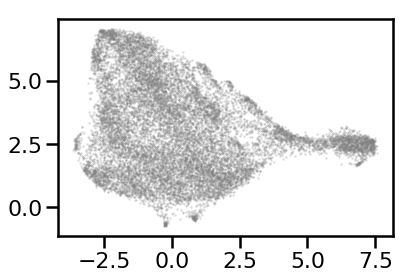

In [32]:
colstring = "umap_euclidean_nn100_md0.1"
scat = plt.scatter(results["X_"+colstring], results["Y_"+colstring], s=5, lw=0, c="grey", alpha=0.3)

data = results["X_"+colstring, "Y_"+colstring].to_pandas().to_numpy()

## Copying from the HDBSCAN tutorial

In [50]:
import hdbscan
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 40, 'linewidths':0}

def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)



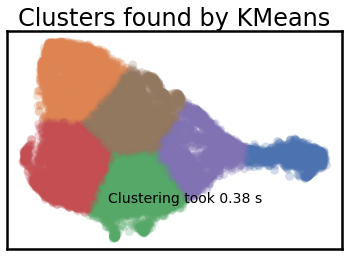

In [35]:
plot_clusters(data, cluster.KMeans, (), {'n_clusters':6})

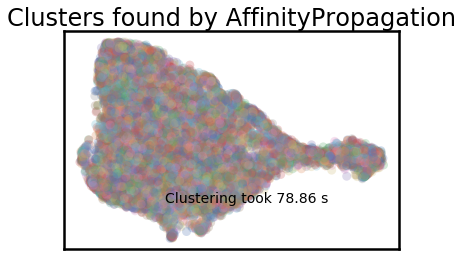

In [36]:
plot_clusters(data, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

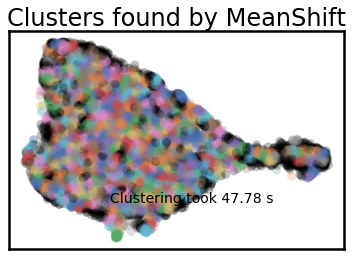

In [37]:
plot_clusters(data, cluster.MeanShift, (0.175,), {'cluster_all':False})

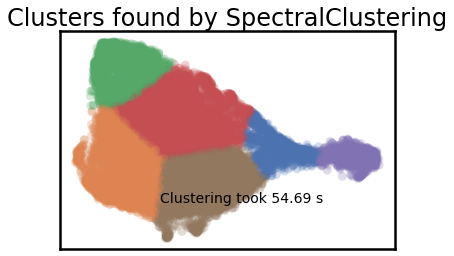

In [38]:
plot_clusters(data, cluster.SpectralClustering, (), {'n_clusters':6})

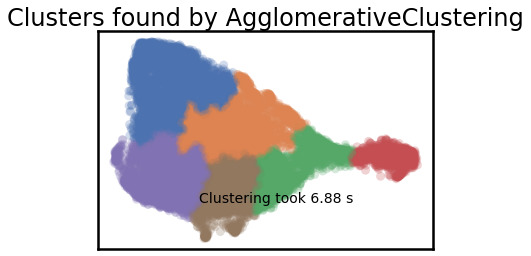

In [39]:
plot_clusters(data, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})

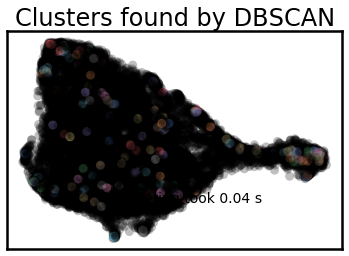

In [40]:
plot_clusters(data, cluster.DBSCAN, (), {'eps':0.025})

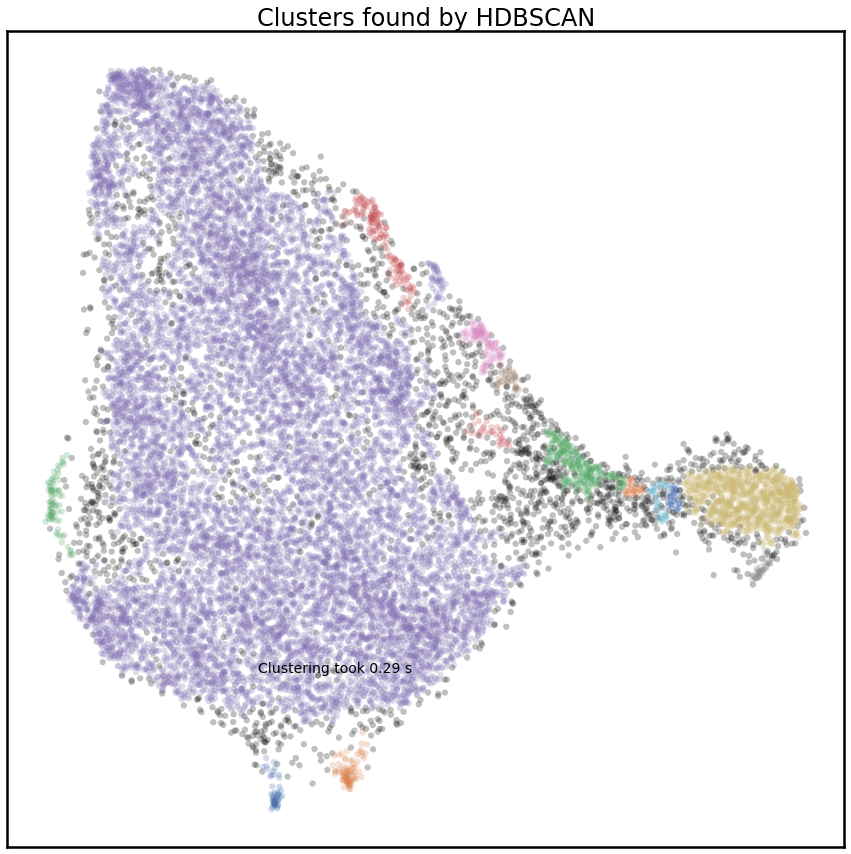

In [81]:
plt.figure(figsize=(15,15))
plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':30, "min_samples":15})

### Extracting the clusters

In [87]:
#algorithm(*args, **kwds).fit_predict(data)

clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, min_samples=15,
    metric='euclidean', min_cluster_size=30, p=None)
clusterer.fit(data)

print(clusterer.labels_)
print(np.unique(clusterer.labels_))

[ 6  6  6 ... 11  6 -1]
[-1  0  1  2  3  4  5  6  7  8  9 10 11]


## Prepare the big plot

The above is now implemented in obtain_data.apogeedr16_rc(). So we simply call:

In [135]:
importlib.reload(obtain_data)

apo_rc = obtain_data.apogeedr16_rc()
apo_rc.get_umap_tsne_colours(p=80, lr=100, nn=100, md=0.1,)
apo_rc.get_umap_subsets(nn=100, md=0.1, min_samples=15, min_cluster_size=30)

16193 stars in your APOGEE DR16 sample all


Now we can adapt Fig. 1 from Anders+2018 for our sample, using the automatically found clusters as subgroups: 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


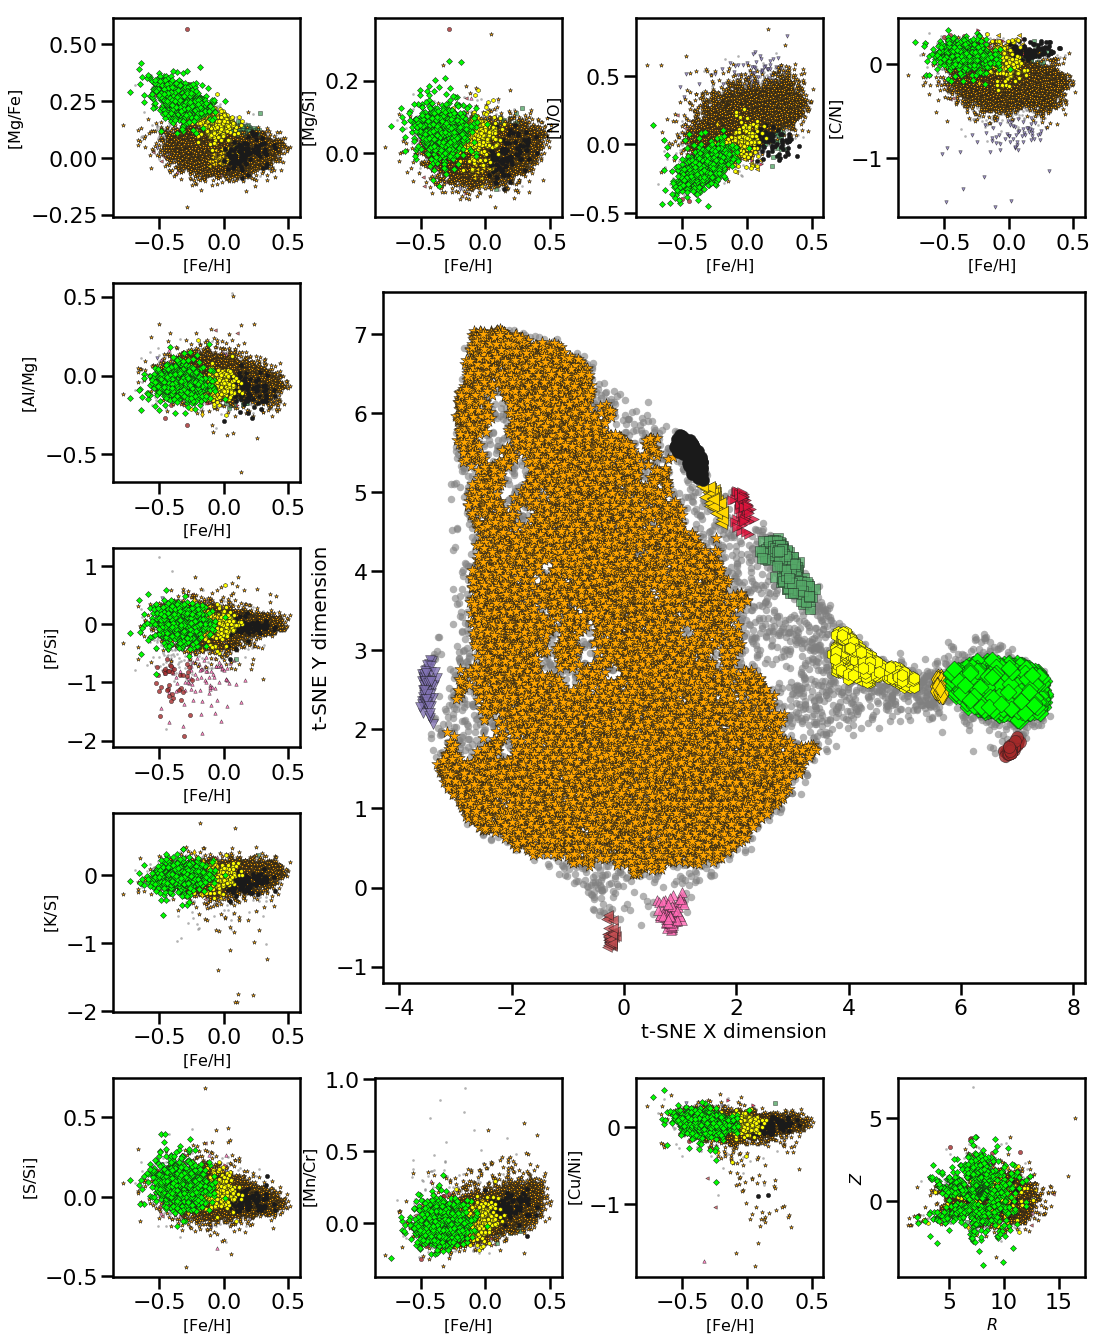

In [136]:
t = apo_rc

# t-SNE + abundances plot

exinds = [ [0,1], [0,2], [0,4], [0,5],
           [0,6], None,  None,  None, 
           [0,7], None,  None,  None, 
           [0,8], None,  None,  None, 
           [0,9],[0,10],[0,11],[13,14] ]
limits = [ None,  None,  None,  None, 
           None,  None,  None,  None, 
           None,  None,  None,  None, 
           None,  None,  None,  None, 
           None,  None,  None,  None ]

#------------------------------------------------------------
# Plot the results
import matplotlib.gridspec as gridspec

g   = plt.figure(figsize=(15, 19))

#################
# abundance plots around
#################
gs = gridspec.GridSpec(5, 4)
gs.update(left=0.08, bottom=0.06, right=0.98, top=0.98,
           wspace=0.4, hspace=0.33)

for jj in range(20):
    print(jj)
    if exinds[jj] != None:
        ax = plt.subplot(gs[int(jj/4), int(jj%4)])
        g.add_subplot(ax)
        for kk in np.arange(len(t.subsets)):
            mask = (t.classcol == t.subsets[kk]) #* (xerr[exinds[jj][1]] < 9.9)
            #ax.errorbar(xx[exinds[jj][0]][mask], xx[exinds[jj][1]][mask],
            #            xerr=xerr[exinds[jj][0]][mask], yerr=xerr[exinds[jj][1]][mask],
            #           ms=0, mec="k", capthick=0, elinewidth=1,
            #           mfc=t.col[kk], alpha=t.al[kk]/4., ecolor=t.col[kk], lw=0,
            #           marker=t.sym[kk], zorder=0)
            ax.scatter(t.colors[exinds[jj][0]][mask], t.colors[exinds[jj][1]][mask],
                       s=t.size[kk], lw=t.lw[kk], edgecolors="k",
                       c=t.col[kk], alpha=t.al[kk],
                       marker=t.sym[kk])
        ax.set_xlabel(t.titles[exinds[jj][0]], fontsize=16)
        ax.set_ylabel(t.titles[exinds[jj][1]], fontsize=16)
        if limits[jj] != None:
            ax.axis(limits[jj])
        ax.locator_params(tight=True, nbins=4)

#################
# t-SNE plot in the center
#################
gs0 = gridspec.GridSpec(1, 1)
gs0.update(left=0.33, bottom=0.275, right=0.98, top=0.78)
ax  = plt.Subplot(g, gs0[0, 0])
g.add_subplot(ax)
for kk in np.arange(len(t.subsets)):
    mask = (t.classcol == t.subsets[kk])
    ax.scatter(t.Xu[mask], t.Yu[mask], s=8*t.size[kk], lw=t.lw[kk], edgecolors="k",
               c=t.col[kk], alpha=t.al[kk], marker=t.sym[kk], label=t.names[kk])
    # Annotate population names
    #if kk < len(t.names):
    #    ax.text(t.Xcoords[kk], t.Ycoords[kk], t.names[kk], fontsize=1.25*t.fsize[kk])
ax.set_xlabel("t-SNE X dimension", fontsize=20)
ax.set_ylabel("t-SNE Y dimension", fontsize=20)
"""ax.text(8.1, 2.6, "Thin Disc", fontsize=30)
ax.text(12, 0, "Thick Disc I+II", fontsize=24)
ax.text(-12.8, -9,"Inner Disc I", fontsize=22)
ax.text(-22.2, -6.3, "Inner Disc II", fontsize=22)
ax.text(-23, 6.2, "Inner disc IV", fontsize=22)
ax.text(-23.2, -3, "Inner Disc III", fontsize=18)
ax.text(8, -8.8, "Outer Disc", fontsize=24)
ax.legend(loc='upper right', fontsize=14)"""
#ax.axis([-13, 25, -8, 10.2])

plt.savefig("../im/apogee_rc_big-umap-abundsplot.png", dpi=200)  
